In [3]:
# common imports
import numpy as np
import os
import sklearn
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost
from xgboost import XGBRFClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


# to make this notebook's output stable across runs
np.random.seed(4)

# to plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [14]:
train = pd.read_csv('../data/train_newfeats_drop.csv')
# test = pd.read_csv('data/test.csv')

#### Testing scores

In [15]:
X= train.drop(['Cover_Type'], axis=1) 
y= train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [21]:
# initialize the classificators
rfc= RandomForestClassifier(random_state=77)
gbc= GradientBoostingClassifier(random_state=77)
etc = ExtraTreesClassifier(random_state=77)
lgbm = lgb.LGBMClassifier(random_state=77)
bc = BaggingClassifier(random_state=77)
abc = AdaBoostClassifier(random_state=77)

# now, create a list with the objects 
models= [rfc, gbc, etc, lgbm, bc, abc]

In [22]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.86


The score in train of model GradientBoostingClassifier is 0.86
The score in test of model GradientBoostingClassifier is 0.80


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.87


The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.86


The score in train of model BaggingClassifier is 0.99
The score in test of model BaggingClassifier is 0.84


The score in train of model AdaBoostClassifier is 0.35
The score in test of model AdaBoostClassifier is 0.36




 - We choose to work with RFC, ETC and LGBMC

## 1. Ensembles

In [8]:
X = train.drop(['Cover_Type', 'Id'], axis= 1)
y = train['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12096, 18)
(3024, 18)
(12096,)
(3024,)


In [38]:
pipe = Pipeline(steps=[
        ('transformer', QuantileTransformer()),
        ('classifier', ExtraTreesClassifier())
])

random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 120, 140],
    'classifier__max_features': [1,2,3],
    'classifier__min_samples_split' : [2,3],
    'classifier__min_samples_leaf' : [1,2,3],
    'classifier__max_features': [1,2,3]
}

extra_trees_params = {
    'classifier': [ExtraTreesClassifier()],
    'classifier__n_estimators': [80, 100, 120],
    'classifier__max_features': [1,2,3],
    'classifier__min_samples_split' : [2,3],
    'classifier__min_samples_leaf' : [1,2,3],
    'classifier__max_features': [1,2,3]
    }

lgbm_params = {
    'classifier': [lgb.LGBMClassifier()],
    'classifier__num_leaves': [ 20, 30, 40],
    'classifier__max_depth': [-1, 0, 1],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__n_estimators': [ 100, 1000, 1500],
    'classifier__objective' : ['multiclass']   
}



search_space = [  
    random_forest_params,
    extra_trees_params,
    lgbm_params
]

clf = RandomizedSearchCV(estimator = pipe,
                  param_distributions = search_space,
                  error_score="raise",
                  cv = 10)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=Pipeline(steps=[('transformer',
                                              QuantileTransformer()),
                                             ('classifier',
                                              ExtraTreesClassifier())]),
                   param_distributions=[{'classifier': [RandomForestClassifier()],
                                         'classifier__max_features': [1, 2, 3],
                                         'classifier__min_samples_leaf': [1, 2,
                                                                          3],
                                         'classifier__min_samples_split': [2,
                                                                           3],
                                         'classifier__n_estimators':...
                                         'classifier__min_samples_split': [2,
                                                             

In [39]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('transformer', QuantileTransformer()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.2, num_leaves=40,
                                objective='multiclass'))])
0.8673954979526826
{'classifier__objective': 'multiclass', 'classifier__num_leaves': 40, 'classifier__n_estimators': 100, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.2, 'classifier': LGBMClassifier(learning_rate=0.2, num_leaves=40, objective='multiclass')}


 - Saving the best model:
 LGBMClassifier(learning_rate=0.2, num_leaves=40, objective='multiclass') with a score of 0.87

In [37]:
import pickle

filename = 'best_ensemble_model'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

## 2. KNN and SVM

In [46]:
pipe = Pipeline(steps=[        
    ('transformer', QuantileTransformer()),
    ("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier()) 
])



svm_params = {
    'classifier': [svm.SVC()],
    'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
}

lsvm_params = {
    'classifier': [LinearSVC()],
    'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
}

knn_params = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [3,5,7]
}

search_space = [             
    svm_params,
    lsvm_params,
    knn_params
]

clf = RandomizedSearchCV(estimator = pipe,
                  param_distributions = search_space,
                  error_score="raise",
                  cv = 10)

clf.fit(X_train, y_train)

c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-p

RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=Pipeline(steps=[('transformer',
                                              QuantileTransformer()),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   param_distributions=[{'classifier': [SVC()],
                                         'classifier__C': [0.001, 0.1, 0.5, 1,
                                                           5, 10, 100]},
                                        {'classifier': [LinearSVC()],
                                         'classifier__C': [0.001, 0.1, 0.5, 1,
                                                           5, 10, 100]},
                                        {'classifier': [KNeighborsClassifier(n_neighbors=3)],
                                         'classifier__n_neighbors': [3, 5, 7]}])

In [47]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('transformer', QuantileTransformer()),
                ('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])
0.7976204636028681
{'classifier__n_neighbors': 3, 'classifier': KNeighborsClassifier(n_neighbors=3)}


Our best model eis the LGBM Classifier with a score of 0.87

Let's look at the features importances:

In [4]:
pipeline = pickle.load(open('../model/best_ensemble_model','rb'))

model = pipeline[1]

train = pd.read_csv('../data/train_newfeats_drop.csv')

In [5]:
X = train.drop(['Cover_Type'], axis= 1)
y = train['Cover_Type']

transformer = QuantileTransformer()

trans_X = transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model.fit(X_train, y_train)

y_test_pred_model = model.predict(X_test)

print (model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.8898809523809523


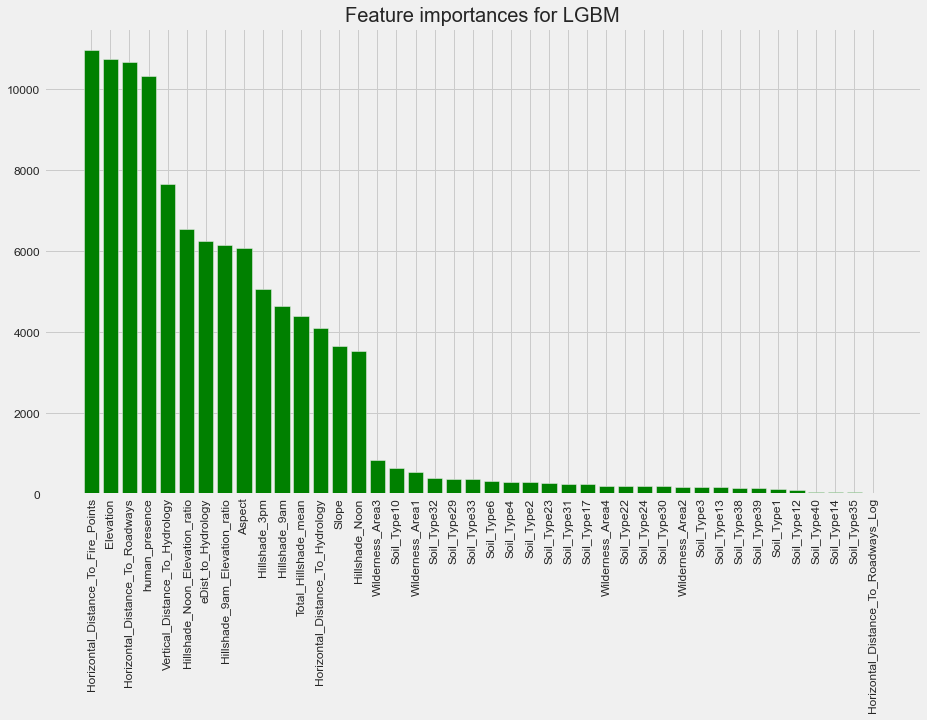

In [7]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (14,8))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#008000')
plt.title('Feature importances for LGBM', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [8]:
X.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type6',
       'Soil_Type10', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type17', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'eDist_to_Hydrology', 'human_presence',
       'Total_Hillshade_mean', 'Horizontal_Distance_To_Roadways_Log',
       'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio'],
      dtype='object')

Let's drop these four non inportant features:

In [9]:
X = train.drop(['Cover_Type', 'Soil_Type40', 'Soil_Type14', 'Soil_Type35', 'Horizontal_Distance_To_Roadways_Log'], axis= 1)
y = train['Cover_Type']

transformer = QuantileTransformer()

trans_X = transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model.fit(X_train, y_train)

y_test_pred_model = model.predict(X_test)

print (model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.8835978835978836


The result is a bit worse, so let's keep the previous model, and perform the model interpretation in the next notebook.